In [1]:
import geopandas as gpd
from glob import glob
import dask.dataframe as da
from dask.distributed import LocalCluster, Client
import matplotlib.pyplot as plt
import os
import rioxarray as rio
import xarray as xr
# from dem_utils import ArcticDEM
from tqdm import tqdm
import numpy as np
import pandas as pd
import numpy as np
from shapely import wkt
# import utils
import cartopy.crs as ccrs
import shapely
from rasterio.features import rasterize
from rasterio.enums import Resampling
import seaborn as sns
# import odc.geo.xr
from cycler import cycler
prj = ccrs.Stereographic(
    central_latitude=90,
    central_longitude=-45,
    true_scale_latitude=70
)


In [15]:
def demote_coords_to_vars(ds: xr.Dataset,
                        coords: str,
                        var_name: str):
    '''
    messy onliner to for reorganizing dataset.
    e.g. dataset with two variables: a (dims: x, y, t) and b (dims: x, y)
    this function will convert it to a dataset with 
    dimensions x, y and add as many `a` variables as there dim `t` is long
    '''
    return xr.merge([
        ds.drop_vars([coords, var_name]),
        xr.merge(
            [ds[var_name].isel({coords:i}).rename(ds[coords][i].item())
            for i in range(len(ds[coords]))], compat='override').drop_vars(coords)]
                    )

def add_geom_mask(geom, buffer, ds):
    # buffer geometry, with square ends
    buff_geom = geom.buffer(200, cap_style=3)
    
    # empty array of same x, y dim shape as merged
    arr = np.zeros((ds.sizes['y'], ds.sizes['x']))
    
    # rasterize
    burned = rasterize(shapes=[(buff_geom, 1)],
                       fill=0,
                       out=arr,
                       transform=ds.rio.transform())
    
    # merged rasterized with all other dataarrays
    merged = xr.merge([ds, xr.DataArray(data=burned,
                                        dims=['y','x'],
                                        coords={'y': ds.y,
                                                'x': ds.x}).rename('buffer_aoi')])

    return merged

class site():
    def __init__(self,
                 id: int,
                 vars: list=['sec', 'dem', 'sample', 'coreg_meta', 'stable_terrain', 'centreline']):
        
        '''
        convenience class for opening output files from directory id
        id = id number of study site directory
        vars = list of variables to include
        returns the opened files
        '''
        
        directories = glob('../data/id*')
        directory = [d for d in directories if f'id{id}' in d]
        assert len(directory) == 1, 'too many or not enough'
        self.directory = directory[0]

        self.paths = {
            'sec': os.path.join(self.directory, 'sec.zarr'),
            'dem': os.path.join(self.directory, 'stacked_coregd.zarr'),
            'sample': os.path.join(self.directory, 'elevation_sample.parquet'),
            'coreg_meta': os.path.join(self.directory, 'coregistration_metadata.parquet'),
            'stable_terrain': os.path.join(self.directory, 'stable_terrain_mask.tif'),
            'centreline': os.path.join(self.directory, glob('line*.geojson', root_dir=self.directory)[0])
            }

        to_remove = []
        for k, v in self.paths.items():
            if os.path.exists(v):
                continue
            else:
                to_remove.append(k)
        
        [self.paths.pop(k) for k in to_remove]
                
        self.open_funcs = {
            '.tif': rio.open_rasterio,
            '.zarr': xr.open_zarr,
            '.parquet': pd.read_parquet,
            '.geojson': gpd.read_file
        }
        
        for var in [var for var in vars if var in self.paths.keys()]:
            _, extension = os.path.splitext(self.paths[var])
            setattr(self, var, self.open_funcs[extension](self.paths[var]))
        
        try:
            self.sec = demote_coords_to_vars(self.sec, 'result', 'sec')
        except:
            pass


In [16]:
data = site(32)

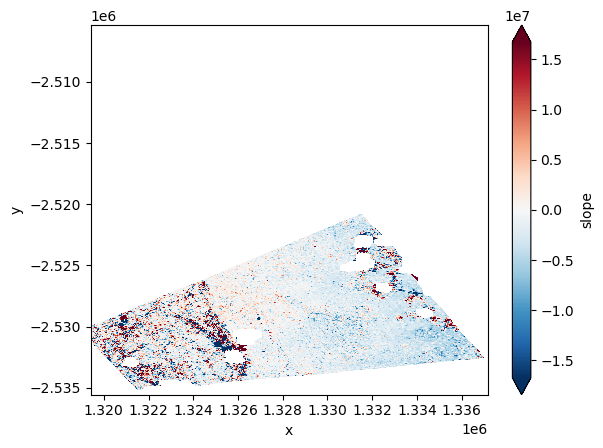

In [19]:
data.sec['slope'].plot(robust=True)

## fix centreline

In [ ]:
## fixing centrelines
centrelines = gpd.read_file('../data/streams_v3.geojson')
sites = glob('../data/id*')
for s in sites:
    id = int(os.path.basename(s).split('_')[0].replace('id',''))
    json_cl_path = glob('*.geojson', root_dir=s)
    json_cl = gpd.read_file(os.path.join(s, json_cl_path[0])).loc[0,'geometry']
    old_cntr = json_cl.centroid
    cl_new = centrelines.loc[id, 'geometry']
    new_cntr = cl_new.centroid
    assert cl_new.equals(json_cl), 'uh oh they are different'
    
    zarr_files = glob('*.zarr', root_dir=s)
    for zarr in zarr_files:
        with xr.open_zarr(os.path.join(s, zarr)) as ds:
            zarr_cl = wkt.loads(ds.attrs['centreline'])
            if zarr_cl.equals(cl_new):
                pass
                # print(f'all good in {zarr}')
                print(s, zarr, ds.dims)
            else:
                print('fuck')
                # # print(f'distance: {zarr_cl.centroid.distance(new_cntr):.2f}')
                # same_ends = zarr_cl.boundary.geoms[-1].equals(cl_new.boundary.geoms[-1])
                # if same_ends:
                #     print(f'the upglacier ends are the same: {same_ends} - overwriting attrs')
                #     ds.attrs.update({'centreline': cl_new.wkt})
                #     ds.to_zarr(os.path.join(s, zarr), mode='a')
                # else:
                #     print('not a clue what to do')

## PLOTTING CENTRELINE SAMPLES

In [ ]:
df = da.concat([da.read_parquet(f) for f in glob('../data/**/elevation_sample.parquet')])
df = df.reset_index(drop=True)
df = df.compute()

# because this one in iceland is probably better described as lake terminating
# df.loc[df['id']=='29', 'lake_land'] = 'lake'

df['z_bins'] = pd.cut(df['z_median'], np.arange(-50,2000,100))
df['mid_bin'] = df['z_bins'].apply(lambda x: int(x.mid))
groups = df.groupby(['where', 'lake_land'])

In [ ]:
fig, ax = plt.subplots(subplot_kw={'aspect':'equal'})
sns.scatterplot(data=df.loc[df['id']=='17'],
                x='x',
                y='y',
                hue='slope',
                ec='none',
                alpha=0.5,
                ax=ax)


In [ ]:
fg = sns.catplot(data=df,
                 x='mid_bin',
                 y='slope',
                 hue='lake_land',
                 col='where',
                #  col_wrap=5,
                 fliersize=0.5,
                 kind='box',
                 )

fg.set(ylim=(-10,10))
fg.set_xticklabels(rotation=30)
fg.map(plt.axhline, y=0, c='k')

In [ ]:
sec = xr.open_zarr('../data/id29_1368245x_-2521726y/sec.zarr/')

In [ ]:
sampled_stack = ArcticDEM.sample_along_line('../data/id29_1368245x_-2521726y/stacked_coregd.zarr/')
sampled_sec = ArcticDEM.sample_along_line('../data/id29_1368245x_-2521726y/sec.zarr/')
sampled_sec = demote_coords_to_vars(sampled_sec, 'result', 'sec')

In [ ]:
sampled_stack.time.max()

In [ ]:
fig, ax = plt.subplots()
sampled_sec['slope'].plot(ax=ax)
ax.axhline(0, c='k')

In [ ]:
idx = (np.abs(sampled['median_after']) < 1) & (sampled['nmad_after'] < 2)

In [ ]:
colors = plt.get_cmap('viridis', len(sampled.time)).colors

fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(1,1,1)
ax.set_prop_cycle(cycler(color=colors))
_ = sampled['z'].sel(time=idx).plot(hue='time', ax=ax, add_legend=False, lw=0.5)
ax.set_ylim(50, 900)
ax.set_xlim(0, 8)

In [ ]:
fg = sns.catplot(data=df.loc[df['where']=='iceland'],
                 x='mid_bin',
                 y='slope',
                 hue='lake_land',
                 col='id',
                 col_wrap=5,
                 fliersize=0.5,
                 kind='box',
                 )

fg.set(ylim=(-10,10))
fg.set_xticklabels(rotation=30)
fg.map(plt.axhline, y=0, c='k')

In [ ]:
centrelines.reset_index().loc[centrelines['where']=='iceland'].explore(tiles = 'https://api.maptiler.com/tiles/satellite-v2/{z}/{x}/{y}.jpg?key=qXXaw6q8a36GQNC8fUDj',
                                                         attr='asdf')

In [ ]:
fig, axs = plt.subplot_mosaic([['greenland_lake', 'iceland_lake'],
                               ['greenland_land', 'iceland_land']],
                              sharex=True, sharey=True)

for where, lake_land in groups.groups:
    axes = f'{where}_{lake_land}'
    _tmp = groups.get_group((where, lake_land))
    
    _tmp = _tmp.loc[_tmp['slope'].abs() < 20]
    
    axs[axes].hexbin(_tmp['z_median'], _tmp['slope'], gridsize=(20,20), extent=(-50,1550,-10,10), cmap='Blues')
    
    # sns.kdeplot(_tmp, x='z_median', y='slope', ax=axs[axes])
    
    axs[axes].set_title(axes)


## results plotting

In [ ]:
# plot sec field and count of arctic DEMs for each site

sites = glob('../data/id*')
for site in sites:

    id = os.path.basename(site).split('_')[0][2:]
    sec = xr.open_zarr(site + '/sec.zarr')
    dem = xr.open_zarr(site + '/stacked_coregd.zarr')

    fig, axs = plt.subplots(ncols=2,
                            subplot_kw={'projection':prj})

    sec['sec'].sel(result='slope').plot(ax=axs[0],
                                        robust=True,
                                        cmap='RdBu',
                                        cbar_kwargs={'shrink': 0.6,
                                                     'label': '(m/yr)'})

    sec['n'].plot(ax=axs[1],
                  cbar_kwargs={'shrink':0.6,
                               'label': 'count'})

    for ax in axs:
        ax.plot(*wkt.loads(sec.attrs['centreline']).coords.xy, c='k', ls=':')

    axs[0].set_title(f'#{id} surface elevation change')
    axs[1].set_title(f'#{id}: count of ArcticDEMs')
    
    # fig.savefig(site + '/sec_result.png', dpi=600, bbox_inches='tight')
    plt.close(fig)

In [ ]:
sites = glob('../data/id*')

colors = {'lake': 'tab:blue',
          'land': 'tab:green'}

markers = {'greenland': 'o',
           'iceland': '+'}

fig, ax = plt.subplots()

dfs = []

for site in tqdm(sites):
    
    id = os.path.basename(site).split('_')[0][2:]
    
    cl_path = os.path.join(site, glob('*.geojson', root_dir=site)[0])
    cl = gpd.read_file(cl_path)
    
    where = cl.loc[0, 'where']
    lake_land = cl.loc[0, 'lake_land']
    
    sec_path = os.path.join(site, 'sec.zarr')
    dem_path = os.path.join(site, 'stacked_coregd.zarr')
    
    sampled_sec = ArcticDEM.sample_along_line(sec_path)
    sampled_sec = demote_coords_to_vars(sampled_sec, 'result', 'sec')
    
    sampled_dem = ArcticDEM.sample_along_line(dem_path, var='z')
    sampled_dem = sampled_dem['z'].median(dim='time').drop_vars('spatial_ref')
    
    sample = xr.merge([sampled_sec,
                       sampled_dem])
    
    df = sample.to_dataframe()
    
    df['where'] = where
    df['lake_land'] = lake_land
    df['id'] = id
    
    dfs.append(df)
    
    # sample.plot.scatter(x='z',
    #                     y='slope',
    #                     color=colors[lake_land],
    #                     marker=markers[where],
    #                     ax=ax
    #                     )

dataframe = da.concat(dfs)

In [ ]:
fig, axs = plt.subplot_mosaic([['greenland'],['iceland']], sharex=True, sharey=True)

directory = '../data/id5_-226289x_-2968847y/'
for directory in glob('../data/id*'):
    id = directory.split('id')[1].split('_')[0]
    
    centreline_filepath = glob('*.geojson', root_dir=directory)
    gdf = gpd.read_file(os.path.join(directory, centreline_filepath[0]))
    where = gdf.loc[0, 'where']
    
    sec_filepath = glob('sec.zarr', root_dir=directory)
    sec_filepath = os.path.join(directory, sec_filepath[0])
    z_filepath = glob('stacked*', root_dir=directory)
    z_filepath = os.path.join(directory, z_filepath[0])
    
    sec_along_line = sample_sec_along_line(sec_filepath)
    z_along_line = sample_sec_along_line(z_filepath, var='z')
    merged = xr.merge([sec_along_line.sel(result='slope').drop_vars('spatial_ref'),
                    z_along_line.median(dim='time')])

    merged[['z', 'sec']].to_dataframe().sort_values(by='z').plot(x='z', y='sec', label=id, ax=axs[where])
    
axs['greenland'].legend(fontsize=8, ncols=3, frameon=False, loc='upper right')
axs['iceland'].legend(fontsize=8, ncols=2, frameon=False)

axs['greenland'].set_title('greenland')
axs['iceland'].set_title('iceland')

axs['iceland'].set_xlabel('elevation (m)')
axs['iceland'].set_ylabel('sec (m/yr)')
axs['greenland'].set_ylabel('sec (m/yr)')

# fig.savefig('../results/elevation_change/sec_against_z.png', dpi=600, bbox_inches='tight')

In [ ]:
# add directory to centrelines geojson
centrelines = gpd.read_file('../data/streams_v3.geojson')
centrelines['directory'] = pd.Series()
for line in centrelines.itertuples():
    cntr = line.geometry.centroid
    centrelines.loc[line.Index, 'directory'] = f'../data/id{line.Index}_{cntr.x:.0f}x_{cntr.y:.0f}y'

In [ ]:
def plot_result(ds, id, ax, plot_err=False):
    
    ds['sec'].sel(result='slope').plot(ax=ax, label=id)
    if plot_err:
        ax.fill_between(
            x=ds.cumulative_distance,
            y1=ds['sec'].sel(result='high_slope').data,
            y2=ds['sec'].sel(result='low_slope').data,
            color='lightgrey')
    ax.axhline(0, c='grey', lw=0.5)

In [ ]:
import cartopy.feature as cfeature
from adjustText import adjust_text
from cycler import cycler
import seaborn as sns

In [ ]:
where = 'greenland'

colors = plt.get_cmap('tab20').colors

fig = plt.figure()

ax = fig.add_subplot(1,2,1)

ax.set_prop_cycle(cycler(color=colors))

axmap = fig.add_subplot(1,2,2, projection=prj)
axmap.add_feature(cfeature.COASTLINE, edgecolor='lightgrey')
centrelines.loc[centrelines['where']==where].plot(ax=axmap, color='k')
gl = axmap.gridlines(crs=ccrs.PlateCarree(),
                     draw_labels=True,
                     y_inline=False)
gl.rotate_labels=False

gl.bottom_labels=True
gl.left_labels=True
gl.top_labels=False
gl.right_labels=False
gl.ylabel_style = {'rotation': 90}


texts = []
for i, row in enumerate(centrelines.loc[centrelines['where'] == where].itertuples()):
    
    sec_file = glob('sec.zarr', root_dir=row.directory)
    assert len(sec_file) == 1, 'not enough / too many files'
    sec_file_path = os.path.join(row.directory, sec_file[0])
    
    sampled = ArcticDEM.sample_along_line(sec_file_path)
    
    plot_result(sampled, row.Index, ax)
    
    
    text = axmap.annotate(
        text=row.Index,
        xy=row.geometry.centroid.coords[0],
        c=colors[i],
        path_effects=[path_effects.withSimplePatchShadow(shadow_rgbFace='lightgrey',
                                                                 alpha=0.9,
                                                                 offset=(1,-1))])
    texts.append(text)
    
_ = adjust_text(texts)

# ax.legend(ncols=2, frameon=False)
ax.set_title(None)
ax.set_ylabel('surface elevation change (m/yr)')
ax.set_xlabel('distance from terminus (km)')

sns.despine(ax=ax)
axmap.set_axis_off()
plt.subplots_adjust(wspace=0.05)

ax.set_title(where)
ax.set_xlim(right=10.4)

fig.savefig(f'../results/elevation_change/{where}_sec.png', dpi=600, bbox_inches='tight')

In [ ]:
fig, axs = plt.subplots(ncols=2, subplot_kw={'projection':prj})

with LocalCluster() as c, c.get_client() as cli:
    with xr.open_dataset('../data/id9_484789x_-1406074y/sec.zarr/',
                         engine='zarr') as ds:
        # counts = ds['z'].isnull().sum(dim=['x', 'y'])
        ds['sec'].sel(result='slope').plot(robust=True, ax=axs[0], cbar_kwargs={'shrink':0.5})
        ds['n'].plot(ax=axs[1], cbar_kwargs={'shrink':0.5})
        cl = wkt.loads(ds.attrs['centreline'])    

for ax in axs:
    ax.plot(*cl.coords.xy, c='k')


In [ ]:
import seaborn as sns
def plot_stat(df, stat, ax):
    # df = get_meta_df(d)
    after = f'{stat}_after'
    before = f'{stat}_before'
    for row in df.iterrows():
        # print(row[0])
        ax.annotate("",
                    xy=(row[1]['to_reg_acqdate1'], row[1][after]),
                    xytext=(row[1]['to_reg_acqdate1'], row[1][before]),
                    arrowprops=dict(arrowstyle='->'))
    
    minx, maxx = df['to_reg_acqdate1'].agg(['min','max'])
    delta = pd.Timedelta('90d')
    ax.set_xlim(minx-delta, maxx+delta)
    ax.set_ylim(*df[[after, before]].melt()['value'].agg(['min','max']))
    
    ax.axhline(0, c='lightgrey', lw=0.5)
    ax.axvline(df.ref_acqdate1.unique()[0], ls=':', c='k')
    ax.set_ylabel(f'{stat} (m)')
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='center')

def plot_coreg(df, ax):
    # df = get_meta_df(d)
    
    plot_df = df[['median_after','median_before','nmad_after','nmad_before']].melt()
    plot_df['when'] = plot_df['variable'].str.split('_').apply(lambda x: x[1])
    plot_df['variable'] = plot_df['variable'].str.split('_').apply(lambda x: x[0])
    sns.violinplot(data=plot_df,
                   x='variable',
                   y='value',
                   hue='when',
                   palette=sns.palettes.color_palette('colorblind')[-2:],
                   hue_order=['before','after'],
                   ax=ax)
    ax.set_ylabel('metres')
    ax.set_xlabel(None)
    ax.axhline(0, c='lightgrey', lw=0.5, zorder=0)
    sns.move_legend(ax, loc='best', title=None)

In [ ]:
directory = '../data/id8_607229x_-1847482y/'
file = glob('stack*', root_dir=directory)

In [ ]:
beach = False

if beach:
    with xr.open_dataset(os.path.join(directory, file[0]), engine='zarr') as ds:
        2+2
else:
    with rio.open_rasterio('../data/id0_-138892x_-3197992y/padded_SETSM_s2s041_W1W1_20180709_10200100727D6100_1020010076EA9B00_2m_lsf_seg1.tif') as ds:
        3+3
        

In [ ]:
xr.open_dataset(os.path.join(directory, file[0]), engine='zarr')['z'].rio.transform()

## velocity

In [ ]:
from dask.distributed import Client, LocalCluster
import pandas as pd
# import itslive
import geopandas as gpd
# from shapely.geometry import Polygon
# from shapely import box
import matplotlib.pyplot as plt
# from matplotlib.collections import LineCollection
# from matplotlib.dates import date2num, DateFormatter, YearLocator
# import seaborn as sns
# import xrspatial as xrs
import numpy as np
import xarray as xr
from tqdm import tqdm
from IPython import display
import importlib
# import imagery
import utils
import velocity_helpers

In [ ]:
# _ = importlib.reload(utils)
# _ = importlib.reload(velocity_helpers)
# _ = importlib.reload(imagery)

In [ ]:
cluster = LocalCluster()
client = Client(cluster)
print(client.dashboard_link)

In [ ]:
## read in lines, and lazily get velocity cubes, centrelines, and robust trends
lines = gpd.read_file('../data/streams_v2.geojson').to_crs(3413)

In [ ]:
V = {}
failed = []
for row in tqdm(lines.sample(3).itertuples()):
    print(f'working on #{row.Index}')
    try:
        V[row.Index] = velocity_helpers.CentreLiner(
            geo=row.geometry,
            buff_dist=500,
            index=row.Index,
            filter_cube=False,
            get_robust_trend=True,
            get_annual_median=False,
            get_rgb=False,
            )
    except Exception as e:
        failed.append((row.Index, e))
        print(f'#{row.Index} did not work because\n{e}')
        continue

## plotting

In [ ]:
fig, axs = plt.subplots(figsize=[15,8],
                        nrows=2,
                        ncols=4,
                        sharex=True,
                        sharey=True)

for k_v, ax in zip(V.items(), axs.flat):
    k, v = k_v
    velocity_helpers.Plotters.rolling_median(v,
                                             ax=ax,
                                         **{'var': 'v',
                                            'ddt_range': ('335d','395d'),
                                            'ddt_bars': False,
                                            'col': 'cumul_dist',
                                            'window': '90d',
                                            'vals':[500, 1_000, 3_000, 5_000]
                                            })
    _point = utils.shapely_reprojector(v.point, 3413, 4326)
    
    ax.set_title(f'#{k}: {_point.y:.2f}N {_point.x:.2f}W\n{lines.loc[k,"name"]}')
    ax.minorticks_off()

# axs.flat[-2].remove()
axs.flat[-1].remove()

now = pd.Timestamp.now().strftime('%y%m%d_%H%M')+ '_'
directory = '../../GitHub/diary/journal_figures'
filename = 'iceland_outlets_annual_v.png'
fig.savefig(directory + now + filename, bbox_inches = 'tight')

In [ ]:
def centreline_theil_slopes(df, **kwargs):
    
    _var = kwargs.get('var', 'v')
    _x = kwargs.get('x', 'mid_date')
    _date_range = kwargs.get('date_range', (pd.Timestamp('1900-01-01'),
                                            pd.Timestamp.now()))
    _ddt_range = kwargs.get('ddt_range', ('0d', '30d'))
    _mad = kwargs.get('mad', 3)
    
    _df = df.loc[df[_x].between(*_date_range)]    

In [ ]:
idx = ((ds['date_dt'] > pd.Timedelta('335d')) & ((ds['date_dt'] <= pd.Timedelta('395d')))).compute()

from scipy.stats.mstats import theilslopes
from scipy.stats import linregress

x = (ds.mid_date[idx] - ds.mid_date[idx].min()) / pd.Timedelta('365.25d')
y = ds['v'][idx,50,50].compute()

nan_idx = y.isnull()

x = x[~nan_idx]
y= y[~nan_idx]

theil_result = theilslopes(y=y, x=x)
lr_result = linregress(x=x, y=y)


X = np.arange(0,30)
theil_fit = (X * theil_result.slope) + theil_result.intercept
lr_fit = (X * lr_result.slope) + lr_result.intercept

fig, ax = plt.subplots()
ax.scatter(x,y)

ax.plot(X, theil_fit, c='r', label='theilslopes')
ax.plot(X, lr_fit, c='g', label='lr')
ax.legend()

In [ ]:
fig, axs = plt.subplots(figsize=[15,8], nrows=5, ncols=3)
# get_velocity.Plotters.date_dt_bars(V[13],
#                                    ('1d','15d'),
#                                    ax=ax,
#                                    **{'vals':[5_000,1_000]})

get_velocity.Plotters.rolling_median(V[13],
                                     ('335d','395d'),
                                     ax=ax,
                                     ddt_bars=False,
                                     **{'var': 'v',
                                        'col': 'cumul_dist',
                                        'window': '180d',
                                        'vals':[1_000, 3_000, 5_000, 10_000]})

- look at underlying dodgy velocity images
TODO look at GRIMpP and MEASUREs

TODO
- PN thinks that relative change is sufficient to *control* for variations in glacier geometry (read: width/size).
- most interested in *relative* change of velocity over final few kilometers.
    - i.e. 

- it all comes from the same raw processed v data

## imagery

In [ ]:
study_sites = gpd.read_file('../data/potential_study_sites_v1.geojson')
study_sites = study_sites.loc[study_sites['notes'].isin(['yes', 'maybe'])]
study_sites.reset_index(drop=True, inplace=True)
study_sites_5k = study_sites.buffer(5_000).to_crs(4326)

In [ ]:
items = imagery.get_annual_median_mosaic(
    study_sites.loc[0,'geometry'],
    buffer_dist=15_000,
    src_crs=study_sites.crs,
    target_crs=4326,
    timeperiod='2023-01-01/2024-01-01',
    months=[8,9],
    )

In [ ]:
(xrs.multispectral.true_color(
    *items.squeeze()
    .transpose('band', 'y', 'x'))
 .plot.imshow(rgb='band')
)

In [ ]:
import stackstac
stackstac.stack(items, assets=['B04', 'B03', 'B02'])